In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as datetime

In [65]:
# df = todas las licencias
# yellow = todos los campos de Yellow
# Y = yellow con index fechas
# Yn = Y con fechas modificadas

## Loading the data

In [66]:
df = pd.read_csv('df.csv')
# yellow = pd.read_csv('yellow.csv')
# green = pd.read_csv('green.csv')
# FHVHV = pd.read_csv('FHVHV.csv')

In [67]:
yellow = df[df['license_class']=='Yellow']
Y = yellow.copy()

In [68]:
Y['date'] = pd.to_datetime(Y['date'], format='%Y/%m')
Y['num_date']=Y.date.map(datetime.datetime.toordinal)
Y.set_index('date',inplace=True)
Y = Y.asfreq('MS')
Y.tail(2)

,license_class,trips_per_day,farebox_per_day,unique_drivers,unique_vehicles,vehicles_per_day,avg_days_vehicles_on_road,avg_hours_per_day_per_vehicle,avg_days_drivers_on_road,avg_hours_per_day_per_driver,...,farebox_per_vehicle,trips_per_month_on_road,farebox_per_month_on_road,daily_farebox_per_trip,daily_farebox_per_vehicle,drivers_vehicles_ratio,monthly_farebox_per_vehicle_on_road,monthly_farebox_per_trip_on_road,monthly_trips_per_vehicle_on_road,num_date
date,,,,,,,,,,,,,,,,,,,,,
2022-12-01,Yellow,109290,2358924,10749,7791,6529,26.0,8.7,22.0,7.5,...,9386.040816,2841540.0,61332024.0,21.584079,361.299433,1.379669,7872.163265,21.584079,364.720832,738490
2023-01-01,Yellow,98569,2335375,10594,7737,6354,25.5,8.2,21.6,7.1,...,9357.195942,2513509.5,59552062.5,23.692794,367.544067,1.369265,7697.048275,23.692794,324.868748,738521


In [69]:
print(f'Missing values: {Y.isnull().any(axis=1).mean()}')

Missing values: 0.0


In [70]:
Y.index.freq

<MonthBegin>

In [71]:
# Verificar que un índice temporal está completo
# ==============================================================================
(Y.index == pd.date_range(start = Y.index.min(),end = Y.index.max(), freq = Y.index.freq)).all()

True

In [72]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y1 = Y.loc[(Y['month_date'] <= '2020-02-01')]

## Linear Regression

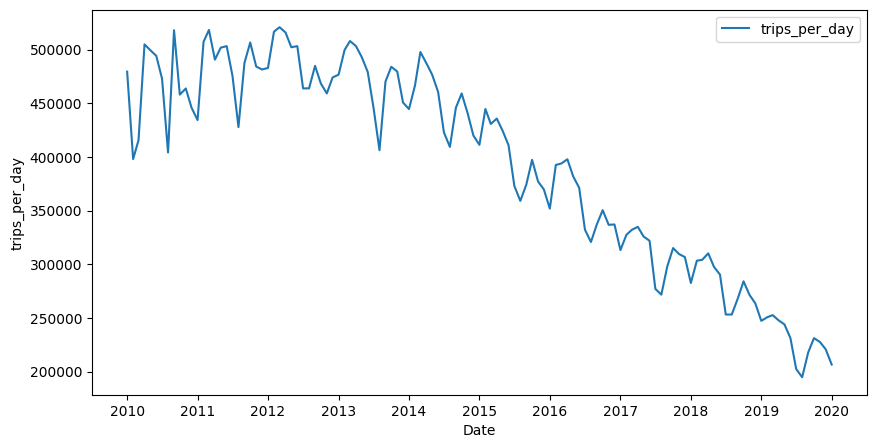

In [73]:
plt.figure(figsize = (10,5))
plt.plot(Y1.index, Y1.trips_per_day, label = 'trips_per_day')
# plt.plot(Y1.month_date, Y1.farebox_per_day, label = 'farebox_per_day')
plt.legend()
plt.xlabel('Date')
plt.ylabel('trips_per_day')
#plt.xlim(datetime.date(2015,1,1), datetime.date(2020,1,1))
plt.show()

In [74]:
from sklearn.linear_model import LinearRegression
reg_lineal = LinearRegression() #Instanciamos el modelo
reg_lineal.fit(Y1.num_date.values.reshape(-1, 1), Y1.trips_per_day) # Lo entrenamos

LinearRegression()

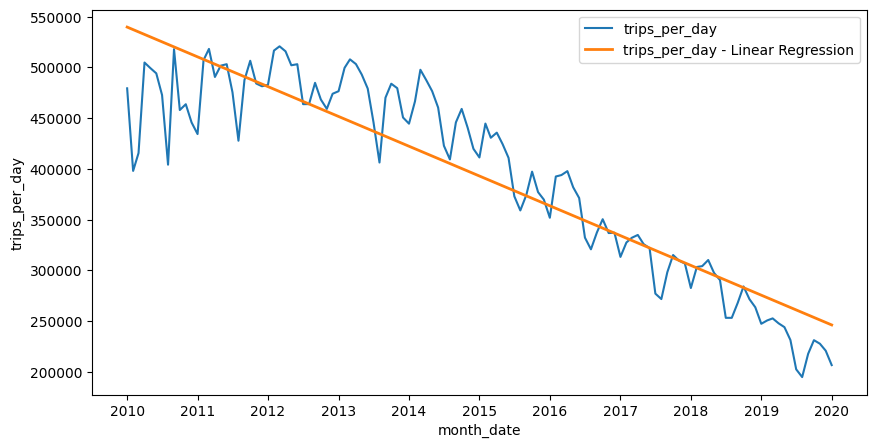

In [75]:
plt.figure(figsize = (10,5)) 
plt.plot(Y1.index, Y1.trips_per_day, label = 'trips_per_day')
plt.plot(Y1.index, reg_lineal.predict(Y1.num_date.values.reshape(-1, 1)), lw = 2, label = 'trips_per_day - Linear Regression')
plt.xlabel('month_date')
plt.ylabel('trips_per_day')
plt.legend()
plt.show()

In [76]:
a = reg_lineal.coef_
b = reg_lineal.intercept_
print('La pendiente es :', a)
print('La ordenada al origen es:', b)

La pendiente es : [-80.3802124]
La ordenada al origen es: 59520560.76949519


In [77]:
Y1['num_date']=Y1.index.map(datetime.datetime.toordinal)

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/3019113033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1['num_date']=Y1.index.map(datetime.datetime.toordinal)


In [78]:
# Obtener el valor proyectado de trips_per_day segun la regresion lineal para una fecha proyectada 'proy_date'.
proy_date = '2024-01-01'
proy_date_datetime = datetime.datetime.strptime(proy_date, '%Y-%m-%d')
x = proy_date_datetime.toordinal()
y = a * x + b
y

array([128747.14980914])

## Estacionalidad

In [79]:
# Agrupamos los datos por mes y mostramos las distribuciones de cada grupo. De esta manera, se visualiza la estacionalidad anual.
# plt.figure(figsize = (10,5))
# sns.boxplot(data=Y,x=Y.index.month,y= Y.trips_per_day)
# plt.title('Annual Seasonality:Trips per day', fontsize = 15)
# plt.xlabel('Month')
# plt.ylabel('Trips per day')
# Preguntar como obtener la estacionalidad de una tendencia descendente

# Modeling ARIMA

In [80]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels as sm

In [81]:
# Y = yellow.copy()
# Y['date'] = pd.to_datetime(Y['date'], format='%Y/%m')
# Y['num_date']=Y.date.map(datetime.datetime.toordinal)
# Y.set_index('date',inplace=True)
# Y = Y.asfreq('MS')
# Y.tail(2)

## Trips per day

In [82]:
# Con datos desde 2010 el r2 es 0.34, probemos acortando los datos desde 2015 a 2020 el r2 es 0.77
y_true = Y1['trips_per_day'].loc['2015-01-01':'2020-01-01']

In [83]:
# Este código ajusta un modelo SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) 
# El modelo SARIMAX tiene un orden de (1,1,1) para los términos ARIMA no estacionales y un orden estacional de (1,1,1,12), 
# lo que indica que se modela una estacionalidad de 12 meses.
# En el parámetro seasonal_orden debemos indicar = p estacional, d estacional, q estacional y periodicidad estacional
model=sm.tsa.statespace.sarimax.SARIMAX(y_true,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72672D+01    |proj g|=  1.82109D+01

At iterate    5    f=  8.16491D+00    |proj g|=  4.09614D-03

At iterate   10    f=  8.16468D+00    |proj g|=  1.40785D-01

At iterate   15    f=  8.14132D+00    |proj g|=  1.97325D-01

At iterate   20    f=  8.14025D+00    |proj g|=  4.56521D-03

At iterate   25    f=  8.14009D+00    |proj g|=  6.96176D-02

At iterate   30    f=  8.13954D+00    |proj g|=  6.71112D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/475480174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1['forecast']=results.predict(start=36,end=59,dynamic=True)


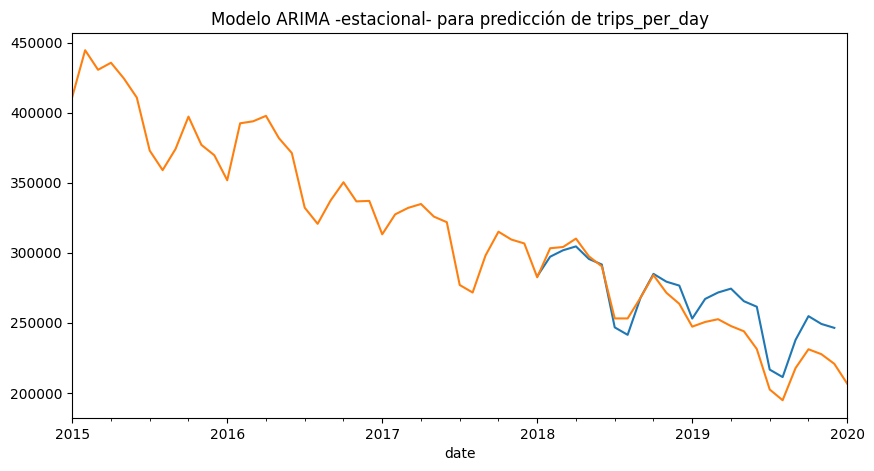

In [84]:
# Comparacion y_true vs y_pred
Y1['forecast']=results.predict(start=36,end=59,dynamic=True)
y_pred = Y1['forecast'].dropna()
y_pred.plot(figsize=(10,5))
y_true.plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de trips_per_day')
plt.show()

In [85]:
# Verifica que ambas series tengan el mismo shape
y_pred = Y1['forecast'].dropna()
y_true = Y1['trips_per_day'].loc['2018-01-01':'2019-12-01']
print(y_pred.shape)
print(y_true.shape)


(24,)
(24,)


In [86]:
# R2 Score: Evaluacion
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.7582899295444605

In [87]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y1['trips_per_day'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04502D+01    |proj g|=  1.90462D+00

At iterate    5    f=  1.00699D+01    |proj g|=  4.01448D-01

At iterate   10    f=  1.00215D+01    |proj g|=  8.85079D-02

At iterate   15    f=  1.00199D+01    |proj g|=  2.36704D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.345D-04   1.002D+01
  F =   10.019886759977890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [88]:
# Prediccion a 4 años  = 48 meses
ventana = 4
meses = 12 * ventana
start = len(Y1['trips_per_day'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y1.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y1.columns)
future_df = pd.concat([Y1,future_datest_df]) # Concatenamos los dos dataframes

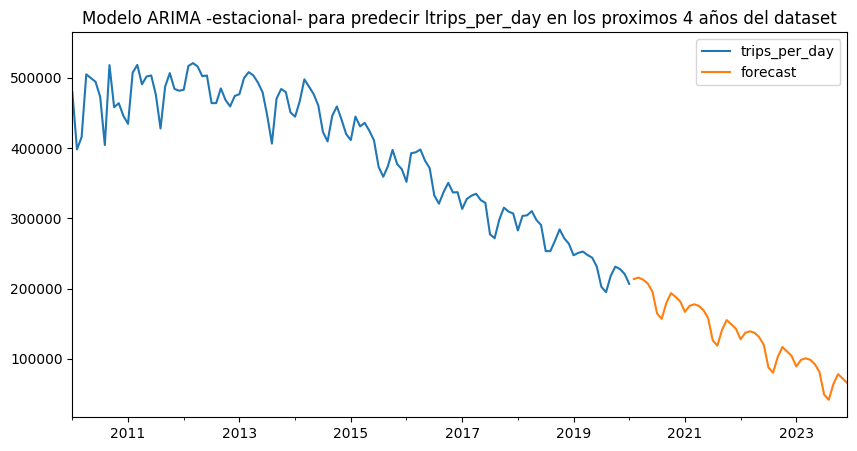

In [89]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df[['trips_per_day', 'forecast']].plot(figsize=(10, 5)) 
plt.plot(Y1.index, reg_lineal.predict(Y1.num_date.values.reshape(-1, 1)), lw = 4, label = 'trips_per_day - Linear Regression')
plt.title('Modelo ARIMA -estacional- para predecir ltrips_per_day en los proximos 4 años del dataset')
plt.show()

### Union tendencia post-COVID

In [90]:
future_df[['trips_per_day', 'forecast']].loc['2019-11-01':'2020-04-01']

,trips_per_day,forecast
2019-11-01,227654,NaN
2019-12-01,220786,NaN
2020-01-01,206604,NaN
2020-02-01,NaN,213377.369946
2020-03-01,NaN,215558.227229
2020-04-01,NaN,212539.628411


In [91]:
# Hallar la fecha post COVID en donde la diferencia entre y_true con y_pred es menor
y_true = Y['trips_per_day'].loc['2020-01-01':'2022-12-01'].dropna()
y_pred = future_df['forecast'].loc['2020-01-01':'2022-12-01'].dropna()
delta = abs(y_true-y_pred)
delta.idxmin()

Timestamp('2022-10-01 00:00:00')

In [92]:
# Empalmar los datos post-COVID a partir de la fecha obtenida: 2022-10-01
y_pred = future_df['forecast'].loc['2020-02-01':'2022-10-01'].dropna()
y_true = Y['trips_per_day'].loc['2022-11-01':'2022-12-01'].dropna()
Y1 = pd.concat([y_pred,y_true])
Y0 = Y['trips_per_day'].loc[:'2020-01-01'].dropna() # Empalmar los datos previos a 2020
Y1 = pd.concat([Y0,Y1])
Y1 = pd.DataFrame(Y1,columns=['trips_per_day'])
Y1['trips_per_day'] = Y1['trips_per_day'].round().astype(int)
Y1

,trips_per_day
2010-01-01,479376
2010-02-01,397969
2010-03-01,415567
2010-04-01,504798
2010-05-01,499374
...,...
2022-08-01,80204
2022-09-01,102637
2022-10-01,116642
2022-11-01,108146


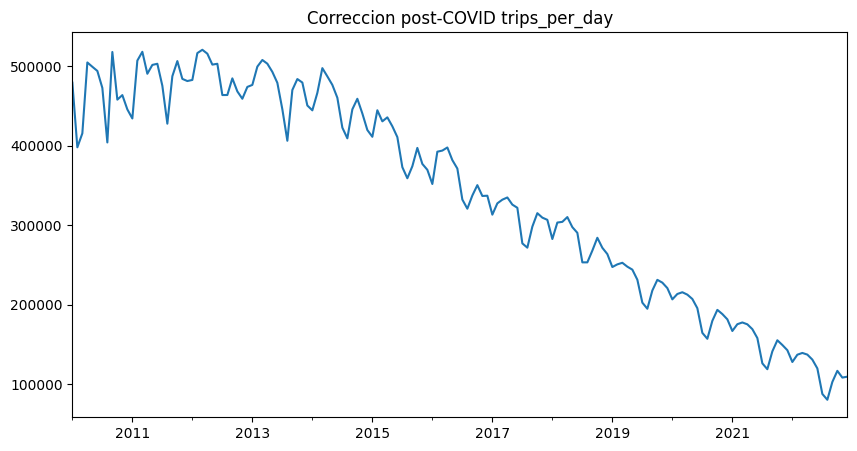

In [93]:
# Graficar Y1
Y1['trips_per_day'].plot(figsize=(10, 5)) 
# Y['trips_per_day'].plot(figsize=(10, 5)) 
plt.title('Correccion post-COVID trips_per_day')
plt.show()

In [94]:
# # Guarda el dataset Proyected Yellow Trips Corregido 2010-2022
proy_Y_trips = Y1['trips_per_day']
proy_Y_trips.to_csv('ML/proy_Y_trips.csv')
Y1 = pd.read_csv('ML/proy_Y_trips.csv') #,index_col=0
Y1['date'] = pd.to_datetime(Y1['Unnamed: 0'], format='%Y/%m')
Y1.set_index('date',inplace=True)
Y1 = Y1.asfreq('MS')
Y1

,Unnamed: 0,trips_per_day
date,,
2010-01-01,2010-01-01,479376
2010-02-01,2010-02-01,397969
2010-03-01,2010-03-01,415567
2010-04-01,2010-04-01,504798
2010-05-01,2010-05-01,499374
...,...,...
2022-08-01,2022-08-01,80204
2022-09-01,2022-09-01,102637
2022-10-01,2022-10-01,116642


### Proyeccion a 3 años desde 2022 a 2025

In [95]:
# Y = yellow.copy()
# Y['date'] = pd.to_datetime(Y['date'], format='%Y/%m')
# Y['num_date']=Y.date.map(datetime.datetime.toordinal)
# Y.set_index('date',inplace=True)
# Y = Y.asfreq('MS')
# Y.tail(2)

In [96]:
# Entrena el modelo corregido hasta fin de 2022
model=sm.tsa.statespace.sarimax.SARIMAX(Y1['trips_per_day'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
# Prediccion a 2 años  = 24 meses
# ventana = 2
# meses = 12 * ventana
# start = len(Y1['trips_per_day'].dropna())+1
# end = start + meses
# from pandas.tseries.offsets import DateOffset
# last_date = pd.to_datetime(Y1.index[-1])
# future_dates = [last_date + DateOffset(months=x) for x in range(1, (meses + 1))]
# future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y1.columns)
# future_df = pd.concat([Y1,future_datest_df]) # Concatenamos los dos dataframes

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05924D+01    |proj g|=  1.91796D+00

At iterate    5    f=  1.02090D+01    |proj g|=  3.40754D-01

At iterate   10    f=  1.01637D+01    |proj g|=  6.04218D-02

At iterate   15    f=  1.01629D+01    |proj g|=  1.04569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   6.110D-05   1.016D+01
  F =   10.162901305457485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [97]:
# Prediccion a 2 años  = 24 meses
ventana = 2
meses = 12 * ventana
start = len(Y1['trips_per_day'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y1.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y1.columns)
future_df = pd.concat([Y1,future_datest_df]) # Concatenamos los dos dataframes

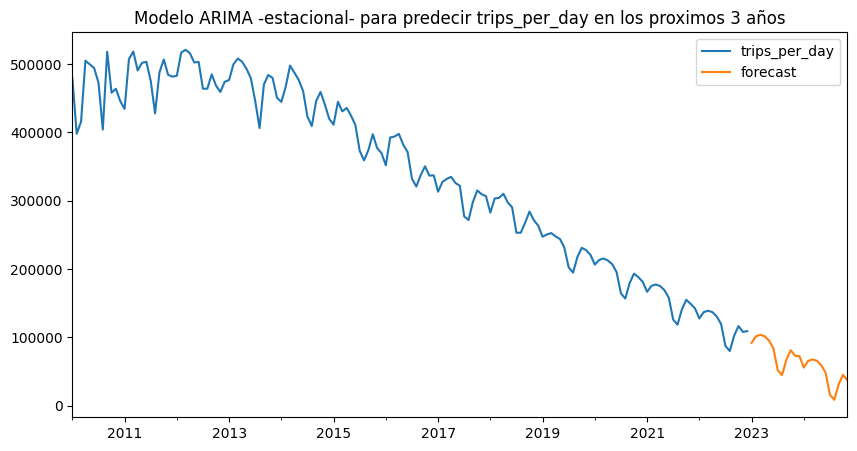

In [98]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df[['trips_per_day', 'forecast']].plot(figsize=(10, 5)) 
plt.title('Modelo ARIMA -estacional- para predecir trips_per_day en los proximos 3 años')
plt.show()

In [99]:
# future_df[['trips_per_day', 'forecast']].iloc['2022-10-01':'2023-02-01']

In [100]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
y_pred = y_pred.round().astype(int)
y_true = future_df['trips_per_day'].dropna()
Y1 = pd.concat([y_true, y_pred])
Y1 = pd.DataFrame(Y1,columns=['trips_per_day'])
Y1

,trips_per_day
2010-01-01,479376
2010-02-01,397969
2010-03-01,415567
2010-04-01,504798
2010-05-01,499374
...,...
2024-07-01,16202
2024-08-01,8871
2024-09-01,31287
2024-10-01,45316


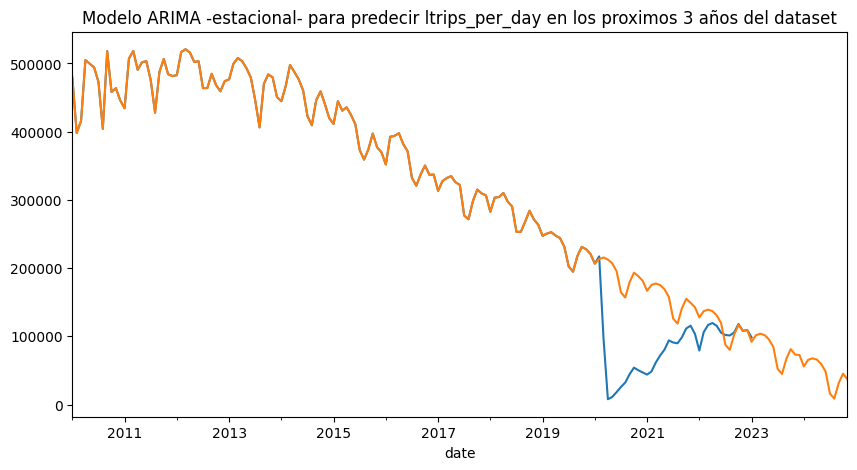

In [101]:
Y['trips_per_day'].plot(figsize=(10, 5))
Y1['trips_per_day'].plot(figsize=(10, 5)) 
plt.title('Modelo ARIMA -estacional- para predecir ltrips_per_day en los proximos 3 años del dataset')
plt.show()

In [102]:
# Guarda el dataset Proyected Yellow Trips Corregido 2010-2024
proy_Y_trips = Y1['trips_per_day']
proy_Y_trips.to_csv('ML/proy_Y_trips.csv')
proy_Y = Y1

## Unique vehicles

In [103]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y2 = yellow[['unique_vehicles','date','month_date']]
Y2['date'] = pd.to_datetime(Y2['date'], format='%Y/%m')
Y2['num_date']=Y2.date.map(datetime.datetime.toordinal)
Y2.set_index('date',inplace=True)
Y2 = Y2.asfreq('MS')
Y2 = Y2.loc['2015-01-01':'2020-01-01']  #
Y2

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/1334520418.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y2['date'] = pd.to_datetime(Y2['date'], format='%Y/%m')
/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/1334520418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y2['num_date']=Y2.date.map(datetime.datetime.toordinal)


,unique_vehicles,month_date,num_date
date,,,
2015-01-01,13633,2015-01-28,735599
2015-02-01,13617,2015-02-28,735630
2015-03-01,13584,2015-03-28,735658
2015-04-01,13577,2015-04-28,735689
2015-05-01,13580,2015-05-28,735719
...,...,...,...
2019-09-01,11302,2019-09-28,737303
2019-10-01,11380,2019-10-28,737333
2019-11-01,11431,2019-11-28,737364


In [104]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y2['unique_vehicles'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21081D+00    |proj g|=  1.04529D-01

At iterate    5    f=  4.17703D+00    |proj g|=  3.52518D-02

At iterate   10    f=  4.17222D+00    |proj g|=  4.14007D-03

At iterate   15    f=  4.16900D+00    |proj g|=  6.74531D-03

At iterate   20    f=  4.16435D+00    |proj g|=  1.64315D-03

At iterate   25    f=  4.16428D+00    |proj g|=  1.71185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   

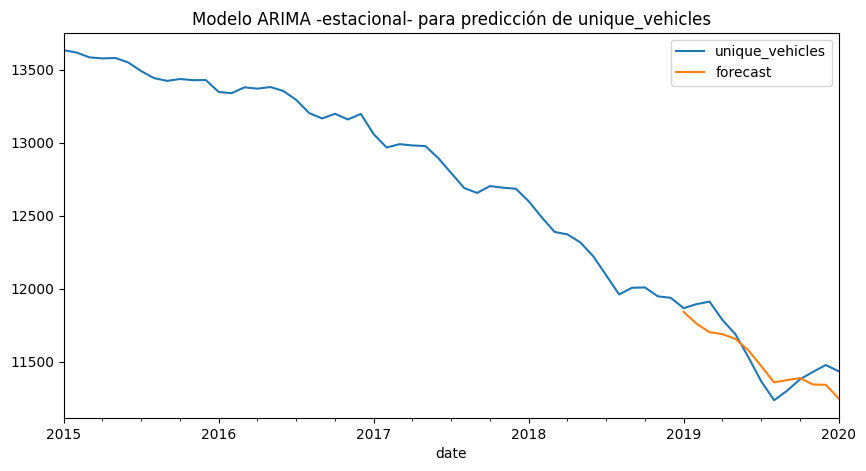

In [105]:
Y2['forecast']=results.predict(start=48,end=60,dynamic=True)
Y2[['unique_vehicles','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de unique_vehicles')
plt.show()

In [106]:
y_pred = Y2['forecast'].dropna()
y_true = Y2['unique_vehicles'].loc['2019-01-01':'2020-01-01']
# R2 Score
from sklearn.metrics import r2_score
r2_score(y_true, y_pred)

0.7540858348604964

In [107]:
# Prediccion a 5 años  = 60 meses
ventana = 5
meses = 12 * ventana
start = len(Y2['unique_vehicles'].dropna())
end = start + meses
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y2.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 3 años = 36 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y2.columns)
future_df = pd.concat([Y2,future_datest_df]) # Concatenamos los dos dataframes

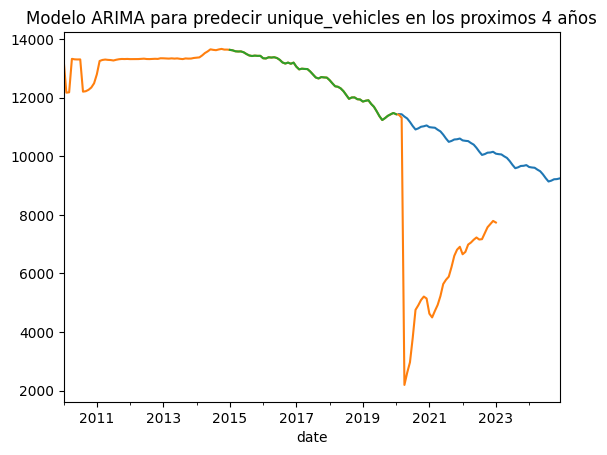

In [108]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df['forecast'].plot() 
Y['unique_vehicles'].plot() 
Y2['unique_vehicles'].plot() 
plt.title('Modelo ARIMA para predecir unique_vehicles en los proximos 4 años')
plt.show()

In [109]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
y_pred = y_pred.round().astype(int)
y_true = Y2['unique_vehicles'].dropna()
Y2 = pd.concat([y_true, y_pred])
Y2 = pd.DataFrame(Y2,columns=['unique_vehicles'])
Y2

,unique_vehicles
2015-01-01,13633
2015-02-01,13617
2015-03-01,13584
2015-04-01,13577
2015-05-01,13580
...,...
2024-08-01,9137
2024-09-01,9166
2024-10-01,9214
2024-11-01,9219


In [110]:
Y2['unique_vehicles'].loc['2020-01-01':'2020-04-01']

2020-01-01    11435
2020-02-01    11439
2020-03-01    11434
2020-04-01    11355
Name: unique_vehicles, dtype: int64

In [111]:
# Guarda el dataset Proyected Yellow Vehicles
proy_Y_vehicles = Y2['unique_vehicles'].dropna()
proy_Y_vehicles.to_csv('ML/proy_Y_vehicles.csv')
proy_Y['unique_vehicles'] = proy_Y_vehicles
proy_Y

,trips_per_day,unique_vehicles
2010-01-01,479376,NaN
2010-02-01,397969,NaN
2010-03-01,415567,NaN
2010-04-01,504798,NaN
2010-05-01,499374,NaN
...,...,...
2024-07-01,16202,9251.0
2024-08-01,8871,9137.0
2024-09-01,31287,9166.0
2024-10-01,45316,9214.0


In [112]:
proy_Y['unique_vehicles'].loc['2020-01-01':'2020-04-01']

2020-01-01    11435.0
2020-02-01    11439.0
2020-03-01    11434.0
2020-04-01    11355.0
Name: unique_vehicles, dtype: float64

## Farebox per day

In [113]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y3 = yellow[['farebox_per_day','date','month_date']]
Y3['date'] = pd.to_datetime(Y3['date'], format='%Y/%m')
Y3['num_date']=Y3.date.map(datetime.datetime.toordinal)
Y3.set_index('date',inplace=True)
Y3 = Y3.asfreq('MS')
Y3 = Y3.loc[:'2020-01-01']  #'2015-01-01'
Y3

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/143422383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y3['date'] = pd.to_datetime(Y3['date'], format='%Y/%m')
/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/143422383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y3['num_date']=Y3.date.map(datetime.datetime.toordinal)


,farebox_per_day,month_date,num_date
date,,,
2010-01-01,4968817,2010-01-28,733773
2010-02-01,3392416,2010-02-28,733804
2010-03-01,3011750,2010-03-28,733832
2010-04-01,5502545,2010-04-28,733863
2010-05-01,5561218,2010-05-28,733893
...,...,...,...
2019-09-01,3814692,2019-09-28,737303
2019-10-01,4006128,2019-10-28,737333
2019-11-01,3872769,2019-11-28,737364


In [114]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y3['farebox_per_day'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28307D+01    |proj g|=  1.21215D+00

At iterate    5    f=  1.26473D+01    |proj g|=  3.14062D-01

At iterate   10    f=  1.26063D+01    |proj g|=  3.68518D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   2.279D-05   1.261D+01
  F =   12.606309838535049     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


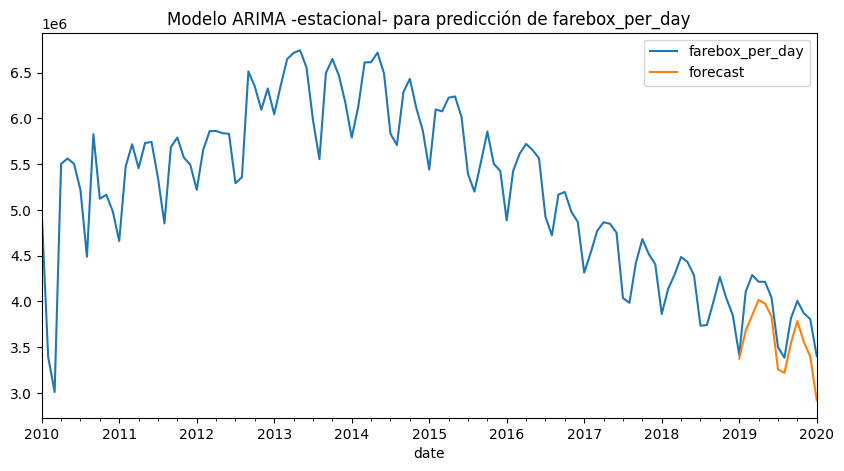

In [115]:
Y3['forecast']=results.predict(start=108,end=120,dynamic=True)
Y3[['farebox_per_day','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de farebox_per_day')
plt.show()

In [116]:
# R2 Score
y_pred = Y3['forecast'].dropna()
y_pred = y_pred.round().astype(int)
y_true = Y3['farebox_per_day'].loc['2019-01-01':]

r2_score(y_true, y_pred)

0.07476480540654384

In [117]:
# Prediccion a 5 años  = 60 meses
ventana = 5
meses = 12 * ventana
start = len(Y3['farebox_per_day'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

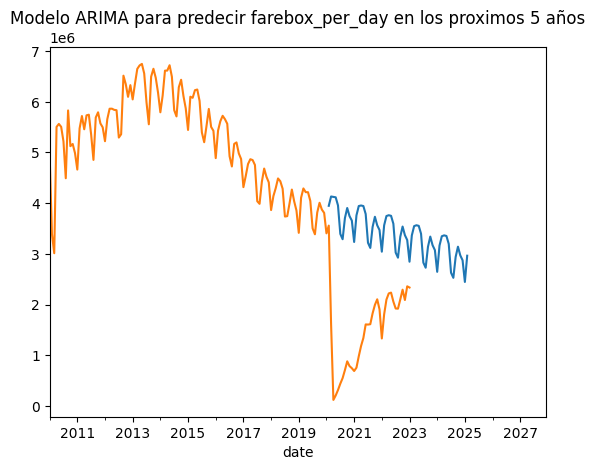

In [118]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df['forecast'].plot() 
# Y3['farebox_per_day'].plot() 
Y['farebox_per_day'].plot() 
plt.title('Modelo ARIMA para predecir farebox_per_day en los proximos 5 años')
plt.show()

In [119]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
y_pred = y_pred.round().astype(int)
y_true = Y3['farebox_per_day'].dropna()
Y3 = pd.concat([y_true, y_pred])
Y3 = pd.DataFrame(Y3,columns=['farebox_per_day'])
Y3

,farebox_per_day
2010-01-01,4968817
2010-02-01,3392416
2010-03-01,3011750
2010-04-01,5502545
2010-05-01,5561218
...,...
2024-10-01,3140369
2024-11-01,2969855
2024-12-01,2873346
2025-01-01,2445231


In [120]:
Y3['farebox_per_day'].loc['2020-01-01':'2020-04-01']

2020-01-01    3403736
2020-02-01    3946565
2020-03-01    4130380
2020-04-01    4123320
Name: farebox_per_day, dtype: int64

In [121]:
# Guarda el dataset Proyected Yellow Vehicles
proy_Y_farebox = Y3['farebox_per_day'].dropna()
proy_Y_farebox.to_csv('ML/proy_Y_farebox.csv')
proy_Y['farebox_per_day'] = proy_Y_farebox
proy_Y

,trips_per_day,unique_vehicles,farebox_per_day
2010-01-01,479376,NaN,4968817
2010-02-01,397969,NaN,3392416
2010-03-01,415567,NaN,3011750
2010-04-01,504798,NaN,5502545
2010-05-01,499374,NaN,5561218
...,...,...,...
2024-07-01,16202,9251.0,2627368
2024-08-01,8871,9137.0,2526630
2024-09-01,31287,9166.0,2939138
2024-10-01,45316,9214.0,3140369


In [122]:
proy_Y['farebox_per_day'].loc['2020-01-01':'2020-04-01']

2020-01-01    3403736
2020-02-01    3946565
2020-03-01    4130380
2020-04-01    4123320
Name: farebox_per_day, dtype: int64

## Average hours per day per vehicle

In [123]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y4 = yellow[['avg_hours_per_day_per_vehicle','date','month_date']]
Y4['date'] = pd.to_datetime(Y4['date'], format='%Y/%m')
Y4['num_date']=Y4.date.map(datetime.datetime.toordinal)
Y4.set_index('date',inplace=True)
Y4 = Y4.asfreq('MS')
Y4 = Y4.loc['2015-01-01':'2020-01-01']  
Y4

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/2738355823.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y4['date'] = pd.to_datetime(Y4['date'], format='%Y/%m')
/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/2738355823.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y4['num_date']=Y4.date.map(datetime.datetime.toordinal)


,avg_hours_per_day_per_vehicle,month_date,num_date
date,,,
2015-01-01,13.4,2015-01-28,735599
2015-02-01,14.1,2015-02-28,735630
2015-03-01,14.0,2015-03-28,735658
2015-04-01,14.2,2015-04-28,735689
2015-05-01,14.1,2015-05-28,735719
...,...,...,...
2019-09-01,10.9,2019-09-28,737303
2019-10-01,11.2,2019-10-28,737333
2019-11-01,11.0,2019-11-28,737364


In [124]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y4['avg_hours_per_day_per_vehicle'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.04844D-01    |proj g|=  1.60119D-01

At iterate    5    f= -5.30069D-01    |proj g|=  1.82610D-02

At iterate   10    f= -5.30743D-01    |proj g|=  6.80743D-02

At iterate   15    f= -5.31560D-01    |proj g|=  2.56810D-01

At iterate   20    f= -5.40869D-01    |proj g|=  2.34218D-02

At iterate   25    f= -5.41323D-01    |proj g|=  6.33303D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f= -5.41478D-01    |proj g|=  9.22111D-04

At iterate   35    f= -5.41489D-01    |proj g|=  2.95467D-03

At iterate   40    f= -5.41512D-01    |proj g|=  1.35992D-01

At iterate   45    f= -5.41707D-01    |proj g|=  6.32896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     85      2     0     0   6.329D-03  -5.417D-01
  F = -0.54170697228460485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


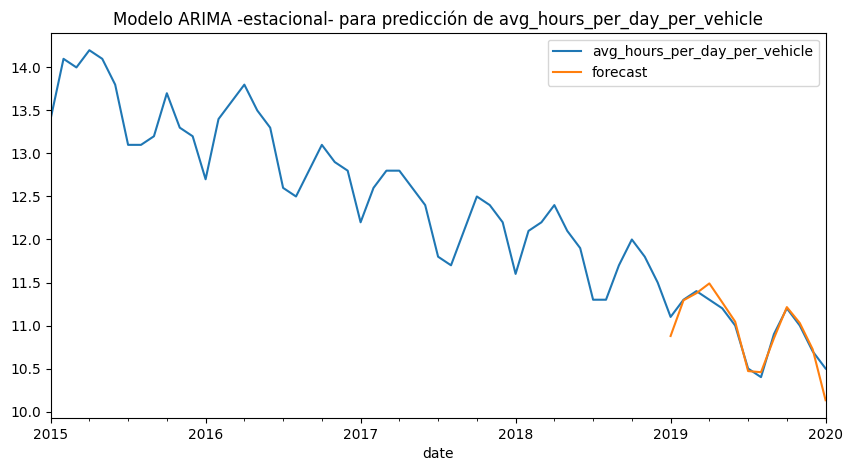

In [125]:
Y4['forecast']=results.predict(start=48,end=60,dynamic=True)
Y4[['avg_hours_per_day_per_vehicle','forecast']].plot(figsize=(10,5))
plt.title('Modelo ARIMA -estacional- para predicción de avg_hours_per_day_per_vehicle')
plt.show()

In [126]:
# R2 Score
y_pred = Y4['forecast'].dropna()
y_true = Y4['avg_hours_per_day_per_vehicle'].loc['2019-01-01':'2020-01-01']
print(y_pred.shape)
print(y_true.shape)
r2_score(y_true, y_pred)

(13,)
(13,)


0.8277629576141701

In [127]:
# Prediccion a 3 años  = 36 meses
ventana = 3
meses = 12 * ventana
start = len(Y4['avg_hours_per_day_per_vehicle'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(1, (meses))]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

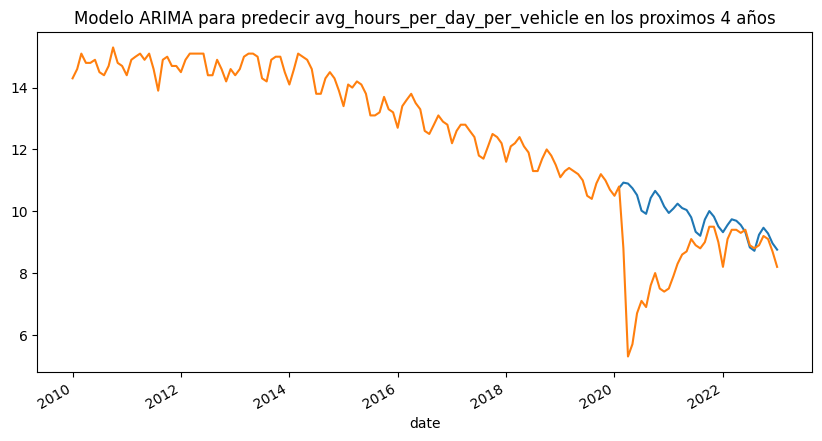

In [128]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df['forecast'].plot(figsize=(10,5)) 
Y['avg_hours_per_day_per_vehicle'].plot(figsize=(10,5)) 
plt.title('Modelo ARIMA para predecir avg_hours_per_day_per_vehicle en los proximos 4 años')
plt.show()

### Union tendencia post_COVID 

In [129]:
# Hallar la fecha post COVID en donde la diferencia entre y_true con y_pred es menor
y_true = Y['avg_hours_per_day_per_vehicle'].loc['2021-01-01':'2022-12-01'].dropna()
y_pred = future_df['forecast'].loc['2021-01-01':'2022-12-01'].dropna()
delta = abs(y_true-y_pred)
delta.idxmin()

Timestamp('2022-07-01 00:00:00', freq='MS')

In [130]:
# Empalmar los datos post-COVID a partir de la fecha obtenida: 2022-07-01
y_pred = future_df['forecast'].loc['2020-03-01':'2022-07-01'].dropna()
y_true = Y['avg_hours_per_day_per_vehicle'].loc['2022-08-01':'2022-12-01'].dropna()
Y4 = pd.concat([y_pred,y_true])
Y0 = Y['avg_hours_per_day_per_vehicle'].loc[:'2020-02-01'].dropna() # Empalmar los datos previos a 2020
Y4 = pd.concat([Y0,Y4])
Y4 = pd.DataFrame(Y4,columns=['avg_hours_per_day_per_vehicle'])
# Y4['trips_per_day'] = Y4['trips_per_day'].round().astype(int)
Y4

,avg_hours_per_day_per_vehicle
2010-01-01,14.3
2010-02-01,14.6
2010-03-01,15.1
2010-04-01,14.8
2010-05-01,14.8
...,...
2022-08-01,8.8
2022-09-01,8.9
2022-10-01,9.2
2022-11-01,9.1


### Proyeccion a 3 años

In [131]:
Y4 = Y4.asfreq('MS')
Y4.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=156, freq='MS')

In [132]:
# Entrena el modelo corregido hasta fin de 2022
model=sm.tsa.statespace.sarimax.SARIMAX(Y4['avg_hours_per_day_per_vehicle'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
# Prediccion a 2 años  = 24 meses
ventana = 2
meses = 12 * ventana
start = len(Y4['avg_hours_per_day_per_vehicle'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y4.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y4.columns)
future_df = pd.concat([Y4,future_datest_df]) # Concatenamos los dos dataframes

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.68960D-01    |proj g|=  5.52027D-01

At iterate    5    f= -2.93983D-01    |proj g|=  2.23336D-01

At iterate   10    f= -2.95739D-01    |proj g|=  2.55663D-01

At iterate   15    f= -3.08643D-01    |proj g|=  8.79397D-02

At iterate   20    f= -3.14044D-01    |proj g|=  5.90811D-02

At iterate   25    f= -3.14955D-01    |proj g|=  2.48393D-03

At iterate   30    f= -3.14957D-01    |proj g|=  1.67204D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

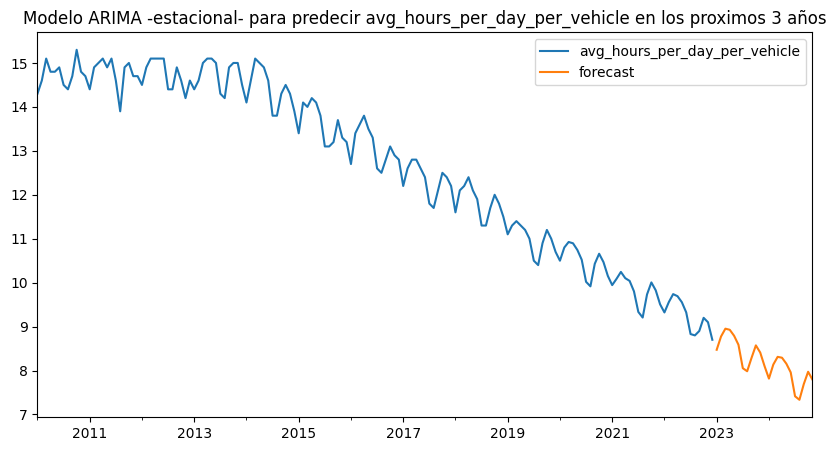

In [133]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df[['avg_hours_per_day_per_vehicle', 'forecast']].plot(figsize=(10, 5)) 
# Y['avg_hours_per_day_per_vehicle'].plot(figsize=(10, 5))
plt.title('Modelo ARIMA -estacional- para predecir avg_hours_per_day_per_vehicle en los proximos 3 años')
plt.show()

In [134]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
# y_pred = y_pred.round().astype(int)
y_true = future_df['avg_hours_per_day_per_vehicle'].dropna()
Y4 = pd.concat([y_true, y_pred])
Y4 = pd.DataFrame(Y4,columns=['avg_hours_per_day_per_vehicle'])
Y4

,avg_hours_per_day_per_vehicle
2010-01-01,14.300000
2010-02-01,14.600000
2010-03-01,15.100000
2010-04-01,14.800000
2010-05-01,14.800000
...,...
2024-07-01,7.414816
2024-08-01,7.334954
2024-09-01,7.690630
2024-10-01,7.972693


In [135]:
Y4['avg_hours_per_day_per_vehicle'].loc['2020-01-01':'2020-04-01']

2020-01-01    10.500000
2020-02-01    10.800000
2020-03-01    10.925967
2020-04-01    10.896136
Name: avg_hours_per_day_per_vehicle, dtype: float64

In [136]:
Y4['avg_hours_per_day_per_vehicle'].loc['2022-08-01':'2023-02-01']

2022-08-01    8.800000
2022-09-01    8.900000
2022-10-01    9.200000
2022-11-01    9.100000
2022-12-01    8.700000
2023-01-01    8.472873
2023-02-01    8.775643
Name: avg_hours_per_day_per_vehicle, dtype: float64

In [137]:
# Guarda el dataset Proyected Yellow Vehicles
proy_Y_hours = Y4['avg_hours_per_day_per_vehicle'].dropna()
proy_Y_hours.to_csv('ML/proy_Y_hours.csv')
proy_Y['avg_hours_per_day_per_vehicle'] = proy_Y_hours
proy_Y

,trips_per_day,unique_vehicles,farebox_per_day,avg_hours_per_day_per_vehicle
2010-01-01,479376,NaN,4968817,14.300000
2010-02-01,397969,NaN,3392416,14.600000
2010-03-01,415567,NaN,3011750,15.100000
2010-04-01,504798,NaN,5502545,14.800000
2010-05-01,499374,NaN,5561218,14.800000
...,...,...,...,...
2024-07-01,16202,9251.0,2627368,7.414816
2024-08-01,8871,9137.0,2526630,7.334954
2024-09-01,31287,9166.0,2939138,7.690630
2024-10-01,45316,9214.0,3140369,7.972693


## Farebox per vehicle

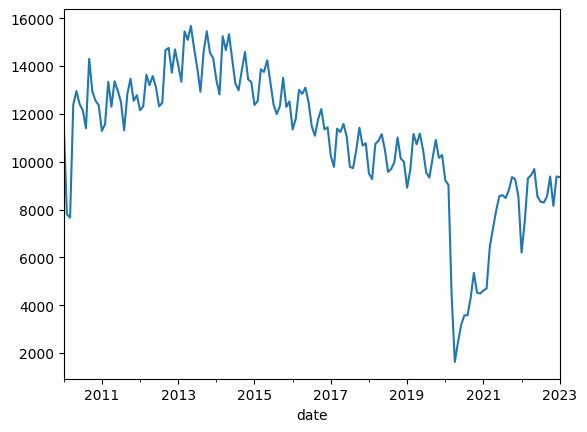

In [138]:
Y['farebox_per_vehicle'].plot()   #.loc['2015-01-01':]
plt.show()

## Trips per vehicle

In [139]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y5 = yellow[['monthly_trips_per_vehicle_on_road','date','month_date']]
Y5['date'] = pd.to_datetime(Y5['date'], format='%Y/%m')
Y5['num_date']=Y5.date.map(datetime.datetime.toordinal)
Y5.set_index('date',inplace=True)
Y5 = Y5.asfreq('MS')
Y5 = Y5.loc['2015-01-01':'2020-01-01']  
Y5

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/3929056778.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y5['date'] = pd.to_datetime(Y5['date'], format='%Y/%m')
/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/3929056778.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y5['num_date']=Y5.date.map(datetime.datetime.toordinal)


,monthly_trips_per_vehicle_on_road,month_date,num_date
date,,,
2015-01-01,871.765437,2015-01-28,735599
2015-02-01,871.829412,2015-02-28,735630
2015-03-01,941.612875,2015-03-28,735658
2015-04-01,927.433078,2015-04-28,735689
2015-05-01,928.308711,2015-05-28,735719
...,...,...,...
2019-09-01,514.408503,2019-09-28,737303
2019-10-01,578.943190,2019-10-28,737333
2019-11-01,545.684507,2019-11-28,737364


In [140]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y5['monthly_trips_per_vehicle_on_road'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.46464D+00    |proj g|=  1.32454D-01

At iterate    5    f=  3.44283D+00    |proj g|=  2.43580D-02

At iterate   10    f=  3.42564D+00    |proj g|=  1.24732D-02

At iterate   15    f=  3.42102D+00    |proj g|=  1.57592D-03

At iterate   20    f=  3.42100D+00    |proj g|=  1.49068D-03

At iterate   25    f=  3.42100D+00    |proj g|=  4.47935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     30      1     0     0   

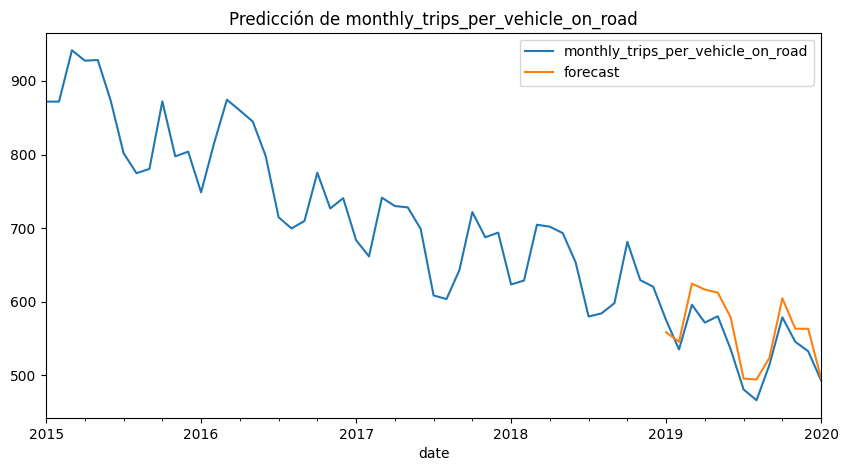

In [141]:
Y5['forecast']=results.predict(start=48,end=60,dynamic=True)
Y5[['monthly_trips_per_vehicle_on_road','forecast']].plot(figsize=(10,5))
plt.title('Predicción de monthly_trips_per_vehicle_on_road')
plt.show()

In [142]:
# R2 Score
y_pred = Y5['forecast'].dropna()
y_true = Y5['monthly_trips_per_vehicle_on_road'].loc['2019-01-01':'2020-01-01']
print(y_pred.shape)
print(y_true.shape)
r2_score(y_true, y_pred)

(13,)
(13,)


0.5515534387428163

In [143]:
# Prediccion a 3 años  = 36 meses
ventana = 3
meses = 12 * ventana
start = len(Y5['monthly_trips_per_vehicle_on_road'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 4 años = 48 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y.columns)
future_df = pd.concat([Y,future_datest_df]) # Concatenamos los dos dataframes

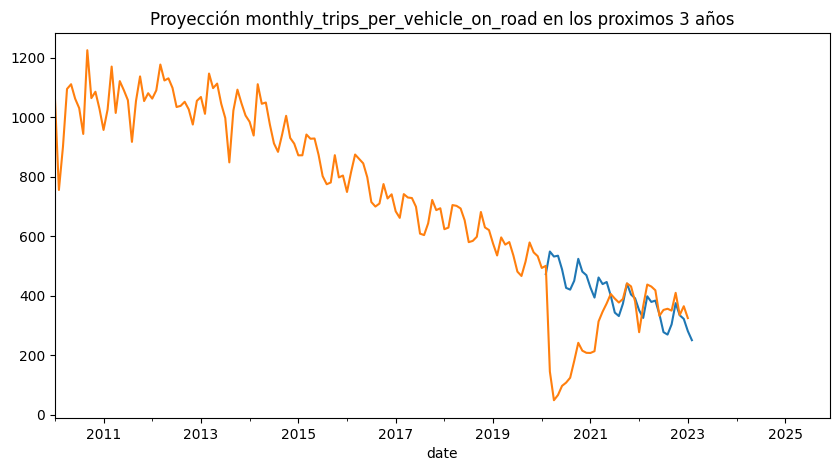

In [144]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df['forecast'].plot(figsize=(10,5)) 
Y['monthly_trips_per_vehicle_on_road'].plot(figsize=(10,5)) 
plt.title('Proyección monthly_trips_per_vehicle_on_road en los proximos 3 años')
plt.show()

### Union tendencia post-COVID 

In [145]:
# Hallar la fecha post COVID en donde la diferencia entre y_true con y_pred es menor
y_true = Y['monthly_trips_per_vehicle_on_road'].loc['2020-01-01':'2022-12-01'].dropna()
y_pred = future_df['forecast'].loc['2020-01-01':'2022-12-01'].dropna()
delta = abs(y_true-y_pred)
delta.idxmin()
# utilizo una fecha anteriora la obtenida

Timestamp('2022-11-01 00:00:00')

In [146]:
# Empalmar los datos post-COVID a partir de la fecha observada en delta: 2021-10-01
y_pred = future_df['forecast'].loc['2020-02-01':'2021-10-01'].dropna()
y_true = Y['monthly_trips_per_vehicle_on_road'].loc['2021-11-01':'2022-12-01'].dropna()
Y5 = pd.concat([y_pred,y_true])
Y0 = Y['monthly_trips_per_vehicle_on_road'].loc[:'2020-01-01'].dropna() # Empalmar los datos previos a 2020
Y5 = pd.concat([Y0,Y5])
Y5 = pd.DataFrame(Y5,columns=['monthly_trips_per_vehicle_on_road'])
# Y5['trips_per_day'] = Y5['trips_per_day'].round().astype(int)
Y5

,monthly_trips_per_vehicle_on_road
2010-01-01,1070.083968
2010-02-01,755.326916
2010-03-01,900.514553
2010-04-01,1094.751778
2010-05-01,1110.637193
...,...
2022-08-01,356.181559
2022-09-01,349.932999
2022-10-01,409.729422
2022-11-01,334.921900


In [147]:
Y5['monthly_trips_per_vehicle_on_road'].loc['2021-12-01':'2023-01-01']

2021-12-01    380.871309
2022-01-01    277.418142
2022-02-01    365.315593
2022-03-01    437.525745
2022-04-01    430.820445
2022-05-01    418.258372
2022-06-01    332.518406
2022-07-01    352.247680
2022-08-01    356.181559
2022-09-01    349.932999
2022-10-01    409.729422
2022-11-01    334.921900
2022-12-01    364.720832
Name: monthly_trips_per_vehicle_on_road, dtype: float64

### Proyeccion a 3 años

In [148]:
Y5 = Y5.asfreq('MS')
Y5.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=156, freq='MS')

In [149]:
# Entrena el modelo corregido hasta fin de 2022
model=sm.tsa.statespace.sarimax.SARIMAX(Y5['monthly_trips_per_vehicle_on_road'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
# Prediccion a 2 años  = 24 meses
ventana = 2
meses = 12 * ventana
start = len(Y5['monthly_trips_per_vehicle_on_road'].dropna())
end = start + meses
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y5.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y5.columns)
future_df = pd.concat([Y5,future_datest_df]) # Concatenamos los dos dataframes

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.98362D+00    |proj g|=  2.30256D-01

At iterate    5    f=  4.91290D+00    |proj g|=  6.50349D-03


 This problem is unconstrained.



At iterate   10    f=  4.91106D+00    |proj g|=  1.32846D-02

At iterate   15    f=  4.90540D+00    |proj g|=  1.06536D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     22      1     0     0   2.539D-05   4.905D+00
  F =   4.9053807118540504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


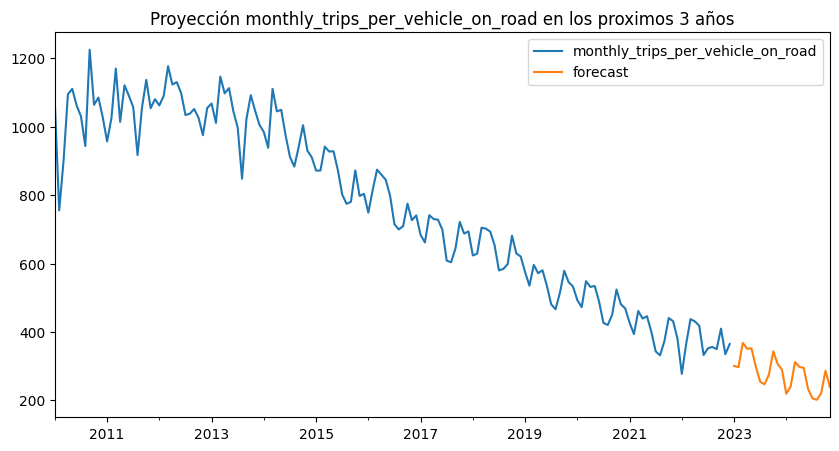

In [150]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df[['monthly_trips_per_vehicle_on_road', 'forecast']].plot(figsize=(10, 5)) 
# Y['avg_hours_per_day_per_vehicle'].plot(figsize=(10, 5))
plt.title('Proyección monthly_trips_per_vehicle_on_road en los proximos 3 años')
plt.show()

In [151]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
# y_pred = y_pred.round().astype(int)
y_true = future_df['monthly_trips_per_vehicle_on_road'].dropna()
Y5 = pd.concat([y_true, y_pred])
Y5 = pd.DataFrame(Y5,columns=['monthly_trips_per_vehicle_on_road'])
Y5

,monthly_trips_per_vehicle_on_road
2010-01-01,1070.083968
2010-02-01,755.326916
2010-03-01,900.514553
2010-04-01,1094.751778
2010-05-01,1110.637193
...,...
2024-07-01,205.978768
2024-08-01,201.754479
2024-09-01,220.666389
2024-10-01,286.542440


In [152]:
# Guarda el dataset Proyected Yellow Vehicles
proy_trips_v = Y5['monthly_trips_per_vehicle_on_road'].dropna()
proy_trips_v.to_csv('ML/proy_trips_v.csv')
proy_Y['monthly_trips_per_vehicle_on_road'] = proy_trips_v
proy_Y

,trips_per_day,unique_vehicles,farebox_per_day,avg_hours_per_day_per_vehicle,monthly_trips_per_vehicle_on_road
2010-01-01,479376,NaN,4968817,14.300000,1070.083968
2010-02-01,397969,NaN,3392416,14.600000,755.326916
2010-03-01,415567,NaN,3011750,15.100000,900.514553
2010-04-01,504798,NaN,5502545,14.800000,1094.751778
2010-05-01,499374,NaN,5561218,14.800000,1110.637193
...,...,...,...,...,...
2024-07-01,16202,9251.0,2627368,7.414816,205.978768
2024-08-01,8871,9137.0,2526630,7.334954,201.754479
2024-09-01,31287,9166.0,2939138,7.690630,220.666389
2024-10-01,45316,9214.0,3140369,7.972693,286.542440


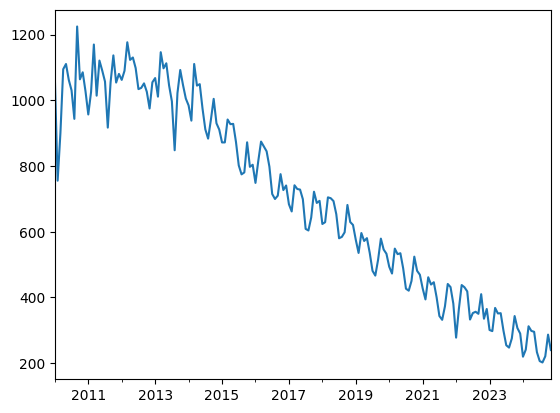

In [153]:
Y5['monthly_trips_per_vehicle_on_road'].plot()   #.loc['2015-01-01':]
plt.show()

# Forecasting ascendente post_COVID

## Unique Vehicles

In [154]:
proy_Y.to_csv('ML/proy_Y.csv')

In [155]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y6 = yellow[['unique_vehicles','date','month_date']]
Y6['date'] = pd.to_datetime(Y6['date'], format='%Y/%m')
Y6['num_date']=Y6.date.map(datetime.datetime.toordinal)
Y6.set_index('date',inplace=True)
Y6 = Y6.asfreq('MS')
Y6 = Y6.loc['2020-05-01':'2023-01-01']  #
Y6

/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/1465823737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y6['date'] = pd.to_datetime(Y6['date'], format='%Y/%m')
/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/1465823737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y6['num_date']=Y6.date.map(datetime.datetime.toordinal)


,unique_vehicles,month_date,num_date
date,,,
2020-05-01,2609,2020-05-28,737546
2020-06-01,2965,2020-06-28,737577
2020-07-01,3803,2020-07-28,737607
2020-08-01,4754,2020-08-28,737638
2020-09-01,4910,2020-09-28,737669
2020-10-01,5092,2020-10-28,737699
2020-11-01,5208,2020-11-28,737730
2020-12-01,5142,2020-12-28,737760
2021-01-01,4625,2021-01-28,737791


In [156]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y6['unique_vehicles'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.49097D+00    |proj g|=  4.87389D-01

At iterate    5    f=  4.33608D+00    |proj g|=  6.22925D-03

At iterate   10    f=  4.31230D+00    |proj g|=  8.25295D-02

At iterate   15    f=  4.24080D+00    |proj g|=  5.33623D-02

At iterate   20    f=  4.18031D+00    |proj g|=  2.47629D-02

At iterate   25    f=  4.16251D+00    |proj g|=  3.13789D-03

At iterate   30    f=  4.16174D+00    |proj g|=  3.20097D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [157]:
# Prediccion a 16 meses
meses = 16 
start = len(Y6['unique_vehicles'].dropna())
end = start + meses
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y6.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 3 años = 36 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y6.columns)
future_df = pd.concat([Y6,future_datest_df]) # Concatenamos los dos dataframes

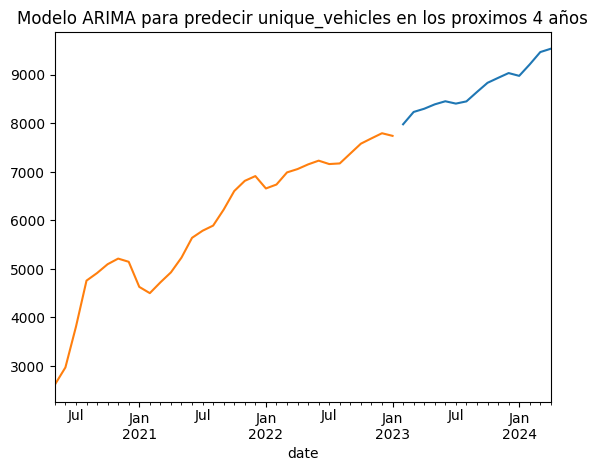

In [158]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df['forecast'].plot() 
# Y['unique_vehicles'].plot() 
Y6['unique_vehicles'].plot() 
plt.title('Modelo ARIMA para predecir unique_vehicles en los proximos 4 años')
plt.show()

In [159]:
# Guarda el dataset Proyected Yellow Vehicles
proy_Y['unique_vehicles_PC'] = future_df['forecast'].dropna()
proy_Y['unique_vehicles_PC'].dropna()

,trips_per_day,unique_vehicles,farebox_per_day,avg_hours_per_day_per_vehicle,monthly_trips_per_vehicle_on_road,unique_vehicles_PC
2010-01-01,479376,NaN,4968817,14.300000,1070.083968,NaN
2010-02-01,397969,NaN,3392416,14.600000,755.326916,NaN
2010-03-01,415567,NaN,3011750,15.100000,900.514553,NaN
2010-04-01,504798,NaN,5502545,14.800000,1094.751778,NaN
2010-05-01,499374,NaN,5561218,14.800000,1110.637193,NaN
...,...,...,...,...,...,...
2024-07-01,16202,9251.0,2627368,7.414816,205.978768,NaN
2024-08-01,8871,9137.0,2526630,7.334954,201.754479,NaN
2024-09-01,31287,9166.0,2939138,7.690630,220.666389,NaN
2024-10-01,45316,9214.0,3140369,7.972693,286.542440,NaN


In [165]:
proy_Y.to_csv('ML/proy_Y.csv')

In [160]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
y_pred = y_pred.round().astype(int)
y_true = Y6['unique_vehicles'].dropna()
Y6 = pd.concat([y_true, y_pred])
Y6 = pd.DataFrame(Y6,columns=['unique_vehicles'])

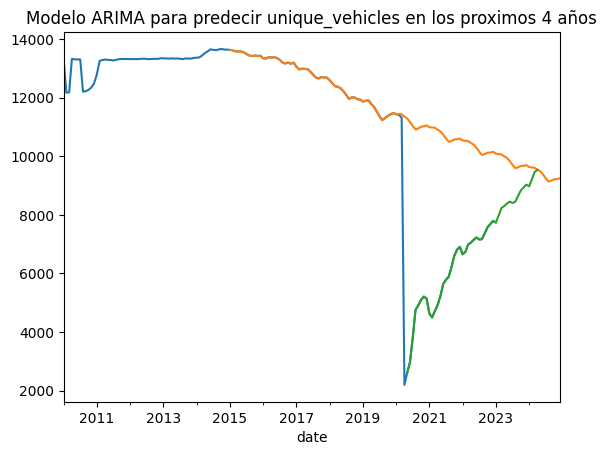

In [161]:
Y['unique_vehicles'].plot() 
Y2['unique_vehicles'].plot() 
Y6['unique_vehicles'].plot()
plt.title('Modelo ARIMA para predecir unique_vehicles en los proximos 4 años')
plt.show()

In [162]:
# Hallar la fecha post COVID en donde se cruzan las 2 proyecciones
desc = Y2['unique_vehicles']
asc = Y6['unique_vehicles']
delta = abs(desc-asc)
delta.idxmin()

Timestamp('2024-04-01 00:00:00')

In [163]:
# # Establecer la fecha de referencia
# fecha_referencia = datetime.datetime(2019, 1, 1)

# # Definir la fecha a convertir
# fecha = datetime.datetime(2025, 1, 1)

# # Calcular la diferencia en días
# diferencia = (fecha - fecha_referencia).days

# # Convertir la diferencia en días a un número entero
# numero_entero = int(diferencia/30)

# # Imprimir el resultado
# print(diferencia)

## Farebox per day

In [177]:
# Limita el dataset hasta fin de 2019 (evita efecto COVID-19)
Y7 = yellow[['farebox_per_day','date','month_date']]
Y7['date'] = pd.to_datetime(Y7['date'], format='%Y/%m')
Y7['num_date']=Y7.date.map(datetime.datetime.toordinal)
Y7.set_index('date',inplace=True)
Y7 = Y7.asfreq('MS')
Y7 = Y7.loc['2020-05-01':]  #'2015-01-01'


/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/678102708.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y7['date'] = pd.to_datetime(Y7['date'], format='%Y/%m')
/var/folders/qr/g6x89n_d48j570j5qt_7mrhr0000gn/T/ipykernel_4096/678102708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y7['num_date']=Y7.date.map(datetime.datetime.toordinal)


In [178]:
model=sm.tsa.statespace.sarimax.SARIMAX(Y7['farebox_per_day'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43348D+00    |proj g|=  1.51607D-01

At iterate    5    f=  8.36382D+00    |proj g|=  7.20366D-03

At iterate   10    f=  8.36257D+00    |proj g|=  9.44810D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   2.379D-06   8.363D+00
  F =   8.3625660028890536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [179]:
# Prediccion a 9 meses
meses = 9 
start = len(Y7['farebox_per_day'].dropna())
end = start + meses
# Prediccion a 4 años
from pandas.tseries.offsets import DateOffset
last_date = pd.to_datetime(Y7.index[-1])
future_dates = [last_date + DateOffset(months=x) for x in range(0, (meses))]
# future_dates = [yellow.index[-1]+ DateOffset(months=x)for x in range(0,36)] # 3 años = 36 meses
future_datest_df = pd.DataFrame(index=future_dates[1:],columns=Y6.columns)
future_df = pd.concat([Y7,future_datest_df]) # Concatenamos los dos dataframes

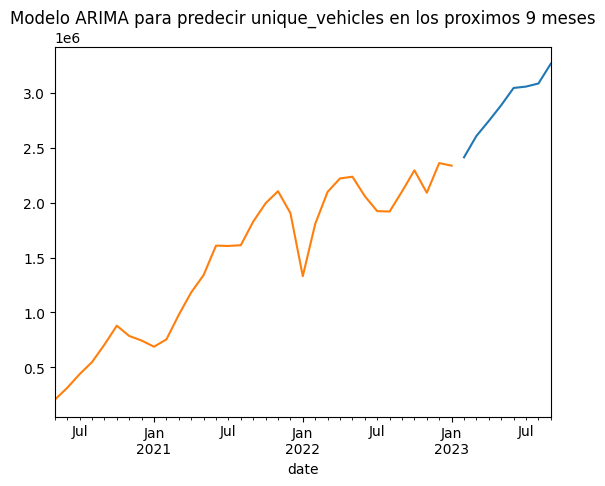

In [180]:
future_df['forecast'] = results.predict(start = start, end = end, dynamic= True)  
future_df['forecast'].plot() 
# Y['unique_vehicles'].plot() 
Y7['farebox_per_day'].plot() 
plt.title('Modelo ARIMA para predecir unique_vehicles en los proximos 9 meses')
plt.show()

In [181]:
# Guarda el dataset Proyected Yellow Vehicles
proy_Y['farebox_per_day_PC'] = future_df['forecast'].dropna()
proy_Y['farebox_per_day_PC'].dropna()

2023-02-01    2.411566e+06
2023-03-01    2.605335e+06
2023-04-01    2.742256e+06
2023-05-01    2.885159e+06
2023-06-01    3.042133e+06
2023-07-01    3.054549e+06
2023-08-01    3.082563e+06
2023-09-01    3.262561e+06
Name: farebox_per_day_PC, dtype: float64

In [182]:
proy_Y.to_csv('ML/proy_Y.csv')

In [183]:
# Empalmar los datos post-COVID a partir de la fecha obtenida
y_pred = future_df['forecast'].dropna()
y_pred = y_pred.round().astype(int)
y_true = Y7['farebox_per_day'].dropna()
Y7 = pd.concat([y_true, y_pred])
Y7 = pd.DataFrame(Y7,columns=['farebox_per_day'])

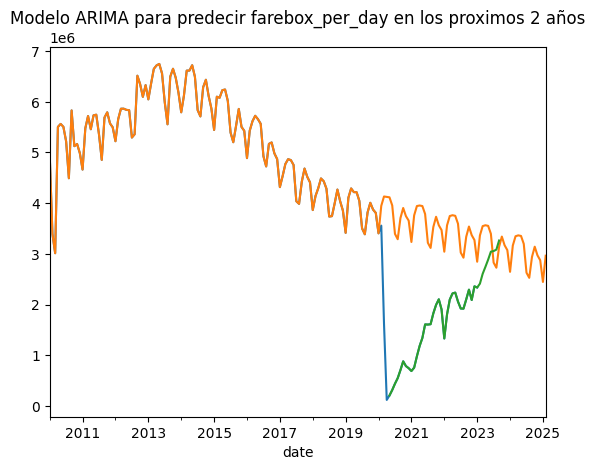

In [184]:
Y['farebox_per_day'].plot() 
Y3['farebox_per_day'].plot() 
Y7['farebox_per_day'].plot()
plt.title('Modelo ARIMA para predecir farebox_per_day en los proximos 2 años')
plt.show()

In [185]:
# Hallar la fecha post COVID en donde se cruzan las 2 proyecciones
desc = Y3['farebox_per_day']
asc = Y7['farebox_per_day']
delta = abs(desc-asc)
delta.idxmin()

Timestamp('2023-09-01 00:00:00')